システム科学専攻 M1 高橋元気 (学生番号 6930-33-6884)
github:https://github.com/genkioffice/bandit

## 概要

このnotebookでは、$\epsilon$ -近傍法とトンプソンサンプリングの比較を行う。レポジトリの構成については、READMEに記載した。以下で行うのは、`models/main.py`と重複する部分が多いため、結果のみを参照したい場合は、`models/main.py`の実行を行う。

## セットアップ

In [1]:
import numpy as np
import sys
sys.path.append("models/")

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from controller import Controller
import params
import policy

matplotlib.rcParams['figure.figsize'] = (8,6)
sns.set()
np.random.seed(2021)

print(f"データ数: {params.N_SIZE}, バッチサイズ: {params.N_BATCH}, ステップ数: {params.N_STEP}")

Duplicate key in file PosixPath('/Users/takahashigenki/.matplotlib/stylelib/genki.mplstyle'), line 176 ('font.family         : IPAexGothic')


データ数: 100000, バッチサイズ: 100, ステップ数: 1000


何回スロットを回すかをデータ数として定義する。100,000回スロットを回す。

## モデル

In [2]:
X = np.array([])
X1, X2, X3, X4 = [0.1], [0.05], [0.02], [0.01]
X = X1 + X2*3 + X3*3 + X4*3
print(f"各腕の正しいパラメータ: {X}")
epsilon = 0.3
e_greedy = policy.EpsilonGreedy(epsilon)
e_cntl = Controller(e_greedy, X)
e_regs, e_rolls = e_cntl.simulate(plot=False)

alpha, beta = 1, 1
thompson = policy.Thompson(alpha, beta)
t_cntl = Controller(thompson, X)
t_regs, t_rolls = t_cntl.simulate(plot=False)


各腕の正しいパラメータ: [0.1, 0.05, 0.05, 0.05, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01]


それぞれのスロットでは、ベルヌーイ分布を仮定している。ベルヌーイ分布のパラメータ$\mu$ は上記のように定められている。<br><br>
$\epsilon$ -貪欲法では、全データに対して比率εで、パラメータを推定し最も高い推定量を得られたスロットから残りの比率分だけスロットを引く。ただし、今回の実装ではバッチごとに比率ε分のデータで推定を行い、残りのバッチ内のデータでスロットを回すようにした。つまり、スロットの出た値が推定に使われるかどうかは確率εで決定される。<br><br>
一方で、トンプソンサンプリングでは、各スロットのパラメータに確率分布を仮定している。スロットの出る値{0, 1}を確率変数とすると、それは平均$\mu$ のベルヌーイ分布に従い、$\mu$ はBeta($\alpha, \beta$)に従うとする。<br>
このとき、事後分布はベルヌーイ分布とベータ分布が共役事前分布であることから容易に計算することができる。$\mu$のサンプリングに事後分布を用い、最も大きな値を得られたスロットを選択するようにする。$\epsilon$ -貪欲法と同様に、実装ではバッチ処理を行っている。<br>



## 結果

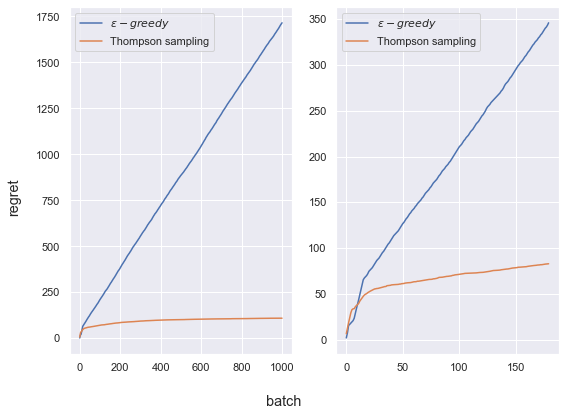

In [3]:
n_sample = len(e_regs)
x = np.arange(n_sample)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.plot(x, e_regs, label="$\epsilon - greedy$")
plt.plot(x, t_regs, label="Thompson sampling")
plt.legend()
fig.add_subplot(1,2,2)

x = np.arange(180)
plt.plot(x, e_regs[:180], label="$\epsilon - greedy$")
plt.plot(x, t_regs[:180], label="Thompson sampling")
plt.suptitle('')
plt.legend()
fig.supylabel('regret')
fig.supxlabel('batch')
plt.tight_layout()
plt.show()

左のグラフは1,000回の各バッチでのregretをplotしたものであり、右のグラフは左のグラフの180バッチまでをプロットしたものである。左のグラフを見ると、$\epsilon$ -貪欲法よりもThomptonサンプリングの方が遥かに精度が良く、二つのアルゴリズムのregretの差は広がっていることがわかる。<br>
一方で、右のグラフでは、数十回分までは$\epsilon$ -貪欲法がトンプソンサンプリングよりも優れていることが分かった。原因は初期値による問題が挙げられる。実装上、正解のパラメータは先頭に置かれ、$\epsilon$近傍では、探索に使われるデータ数が多い。標本平均は0で初期化されているため、探索に使われたデータ数が多いほどその腕は有利である。<br>
<br>
また、$\epsilon$近傍でregretが単調に増加している理由は、バッチ処理によるためである。どのバッチでも探索にデータを割かなければならないため、その分regretが増加している。トンプソンサンプリングで徐々にregretが緩やかになっていくのは、最も大きなパラメータを持つスロットの事後分布のパラメータが他のスロットの事後分布よりも大きく離れていくためであると考えられる。

100%|██████████| 100/100 [00:43<00:00,  2.27it/s]


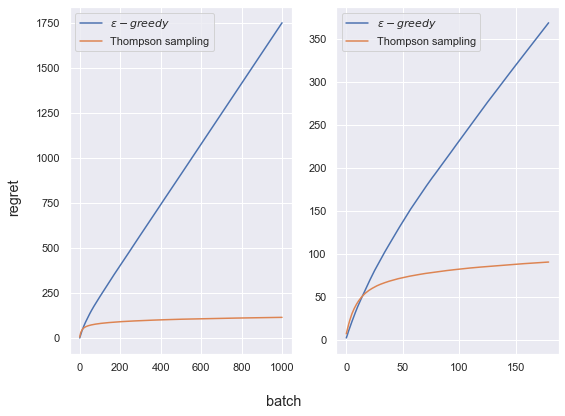

In [5]:
from tqdm import tqdm
es_regs, ts_regs = [],[]

for fold in tqdm(np.arange(100)):
    e_greedy = policy.EpsilonGreedy(epsilon)
    e_cntl = Controller(e_greedy, X)
    e_regs, e_rolls = e_cntl.simulate(plot=False)
    es_regs.append(e_regs)

    alpha, beta = 1, 1
    thompson = policy.Thompson(alpha, beta)
    t_cntl = Controller(thompson, X)
    t_regs, t_rolls = t_cntl.simulate(plot=False)
    ts_regs.append(t_regs)

es_regs = np.array(list(map(np.mean,np.array(es_regs).T)))
ts_regs = np.array(list(map(np.mean,np.array(ts_regs).T)))



n_sample = len(es_regs)
x = np.arange(n_sample)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.plot(x, es_regs, label="$\epsilon - greedy$")
plt.plot(x, ts_regs, label="Thompson sampling")
plt.legend()
fig.add_subplot(1,2,2)

x = np.arange(180)
plt.plot(x, es_regs[:180], label="$\epsilon - greedy$")
plt.plot(x, ts_regs[:180], label="Thompson sampling")
plt.suptitle('')
plt.legend()
fig.supylabel('regret')
fig.supxlabel('batch')
plt.tight_layout()
plt.show()

上記の結果は100回を1つのbatchとして、1000回繰り返したものを100回試行した結果を平均したものである。つまり、100,000時刻分の試行を100回繰り返し、各時刻のregretの100個のサンプルの標本平均を表している。<br><br>
これは、一回試行の場合と同様に、時刻数十までは、トンプソンサンプリングよりも$\epsilon$近傍の方が性能が良いことを表している。結果の評価については一回試行のときと変わりはない。